In [1]:
import cv2
import numpy as np
import random

import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

SEED = 0

torch.manual_seed(SEED)
random.seed = SEED
np.random.seed = SEED

In [2]:
BASE_PATH = "data"
BATCH_SIZE = 32
N_CLASSES = 250

N_EPOCHS = 50
LR = 1e-3

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.current_device())  # Returns the current device ID
print(torch.cuda.get_device_name(0))  # Returns the GPU name

True
0
Tesla V100-SXM2-32GB


## Step 1: Data preprocessing

In [4]:
def show_img(img, title :str =None):
    # Convert the BGR image to RGB
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display the image using Matplotlib
    plt.imshow(image_rgb)
    plt.axis('off')  # Turn off the axis
    plt.title(title)  # Optional: Set a title
    plt.show()

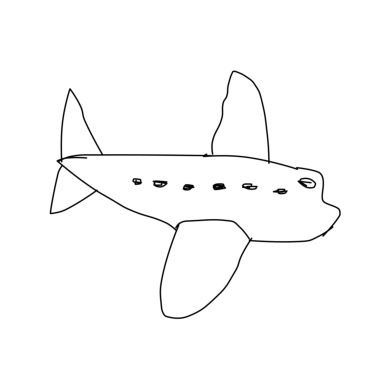

In [5]:
img = cv2.imread(BASE_PATH + "/airplane/1.png")
show_img(img)

In [6]:
import os
import pandas as pd

def load_image_dataset(root_dir=BASE_PATH):
    # Lists to store paths and classes
    image_paths = []
    class_names = []
    
    # Walk through all classes in the root directory
    for class_name in os.listdir(root_dir):
        class_dir = os.path.join(root_dir, class_name)
        if os.path.isdir(class_dir):
            # Get all PNG files in the class directory
            for img_name in os.listdir(class_dir):
                if img_name.endswith('.png'):
                    img_path = os.path.join(class_dir, img_name)
                    image_paths.append(img_path)
                    class_names.append(class_name)
    
    # Create DataFrame
    df = pd.DataFrame({
        'img_path': image_paths,
        'class_name': class_names
    })
    
    return df

# Usage
df = load_image_dataset()
print(df.head())

               img_path class_name
0   data/airplane/1.png   airplane
1  data/airplane/10.png   airplane
2  data/airplane/11.png   airplane
3  data/airplane/12.png   airplane
4  data/airplane/13.png   airplane


In [7]:
N_CLASSES = len(df.class_name.unique())

In [8]:
class SketchDataset(Dataset):
    def __init__(self, df, transforms, label_encoder):
        self.df = df
        self.transforms = transforms
        self.label_encoder = label_encoder
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 0])
        augmented = self.transforms(image=image)

        # Encode label
        label = self.df.iloc[idx, 1]
        if self.label_encoder:
            label = self.label_encoder.transform([label])[0]
        
        image = augmented["image"]
        return image, label

### 1.1 Data augmentation

In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split

In [10]:
PATCH_SIZE = 224

transforms = A.Compose([
    A.Resize(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.2),

    # Added recently 
    A.ElasticTransform(alpha=1.0, sigma=50, alpha_affine=50, p=0.2),
    A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.3),
    A.GridDistortion(num_steps=5, distort_limit=0.1, p=0.3),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    
    A.VerticalFlip(p=0.2),
    A.RandomRotate90(p=0.2),
    A.Transpose(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
    A.Normalize(p=1.0),
    ToTensorV2(),
])

/tmp/ipykernel_235/1277082413.py:8: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(alpha=1.0, sigma=50, alpha_affine=50, p=0.2),


In [11]:
train_df, val_df = train_test_split(df, stratify=df.class_name, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, stratify=train_df.class_name, test_size=0.12)
train_df = train_df.reset_index(drop=True)

print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (15840, 2) 
Val: (2000, 2) 
Test: (2160, 2)


In [12]:
from sklearn.preprocessing import LabelEncoder

# 1. Get all unique labels
all_labels = (
    list(train_df['class_name'].unique()) + 
    list(val_df['class_name'].unique()) + 
    list(test_df['class_name'].unique())
)
all_labels = list(set(all_labels))  # Remove duplicates

# 2. Initialize and fit label encoder
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

LabelEncoder()

In [13]:
train_dataset = SketchDataset(train_df, transforms=transforms, label_encoder=label_encoder)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=True)

val_dataset = SketchDataset(val_df, transforms=transforms, label_encoder=label_encoder)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=True)

test_dataset = SketchDataset(test_df, transforms=transforms, label_encoder=label_encoder)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=True)

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def show_aug(inputs, nrows=5, ncols=5, norm=False):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0., hspace=0.)
    i_ = 0
    
    if len(inputs) > 25:
        inputs = inputs[:25]
        
    for idx in range(len(inputs)):
    
        # normalization
        if norm:           
            img = inputs[idx].numpy().transpose(1,2,0)
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225] 
            img = (img*std+mean).astype(np.float32)
            
        else:
            img = inputs[idx].numpy().astype(np.float32)
            if img.ndim > 2:  # 3x128x128 shape
                img = img[0, :, :]
        
        plt.subplot(nrows, ncols, i_+1)
        plt.imshow(img)
        plt.axis('off')
 
        i_ += 1
        
    return plt.show()

torch.Size([32, 3, 224, 224])


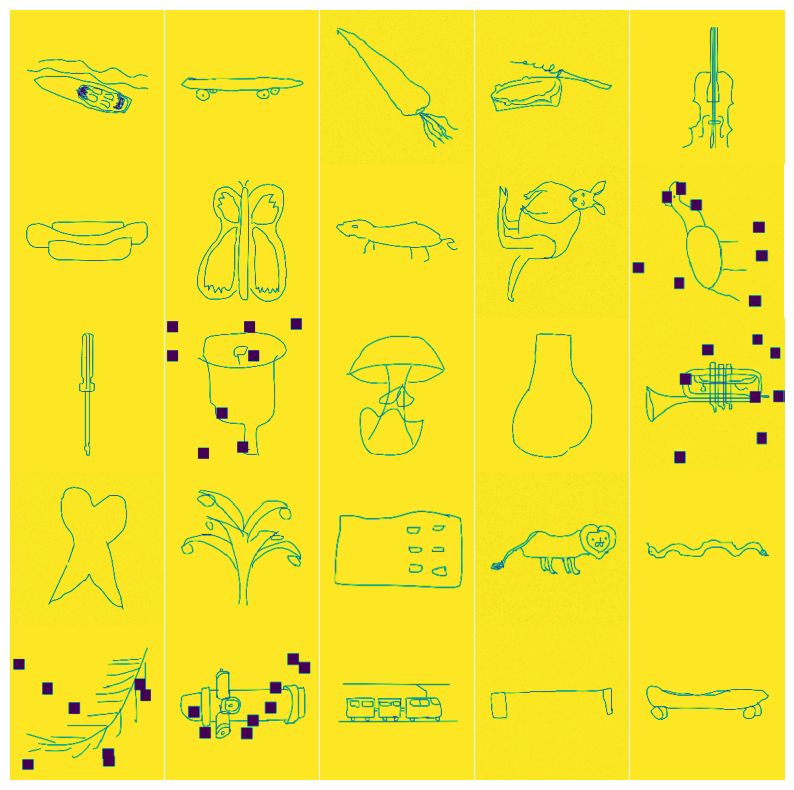

tensor([198, 189,  46,   7, 241, 108,  35, 135, 114,  59, 181,  19, 138, 240,
        236, 227,  51, 113, 123, 193,  80,  81, 231,  20, 189, 138,  10,  26,
        249,  38,  21, 160])


In [15]:
images, y = next(iter(train_dataloader))
print(images.shape)

show_aug(images)
print(y)

In [16]:
# check sanity
output = torch.randn(1, 3, 256, 256).to(device)
output.shape

torch.Size([1, 3, 256, 256])

## Step 2: Modelling

### 2.1 Metric and loss

In [17]:
!pip install torchmetrics

Defaulting to user installation because normal site-packages is not writeable


In [18]:
from torchmetrics import Accuracy
from torchmetrics.classification import MulticlassAccuracy
from torchmetrics.classification import MulticlassF1Score
from torchmetrics import Accuracy, F1Score
from torch.nn import CrossEntropyLoss

# CrossEntropyLoss combines LogSoftmax and NLLLoss
loss = nn.CrossEntropyLoss()

accuracy = Accuracy(task="multiclass", num_classes=N_CLASSES)
f1_score = MulticlassF1Score(num_classes=N_CLASSES)

In [19]:
from tqdm import tqdm

def train_model(model_name, model, train_loader, val_loader, optimizer, lr_scheduler=None, num_epochs=100, num_classes=10):
    print(f"[INFO] Model is initializing... {model_name}")
    
    # Initialize metrics
    criterion = CrossEntropyLoss().to(device)
    accuracy_metric = Accuracy(task="multiclass", num_classes=num_classes).to(device)
    f1_metric = F1Score(task="multiclass", num_classes=num_classes).to(device)
    
    # History tracking
    history = {
        'train_loss': [], 'train_acc': [], 'train_f1': [],
        'val_loss': [], 'val_acc': [], 'val_f1': []
    }
    
    for epoch in range(num_epochs):
        model.train()
        epoch_losses = []
        epoch_acc = []
        epoch_f1 = []
        
        # Training loop
        for data, target in tqdm(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            outputs = model(data)
            
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            
            # Compute metrics
            acc = accuracy_metric(outputs, target)
            f1 = f1_metric(outputs, target)
            
            epoch_losses.append(loss.item())
            epoch_acc.append(acc.item())
            epoch_f1.append(f1.item())
        
        # Validation loop
        model.eval()
        val_losses, val_acc, val_f1 = [], [], []
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                
                val_loss = criterion(outputs, target)
                val_acc_batch = accuracy_metric(outputs, target)
                val_f1_batch = f1_metric(outputs, target)
                
                val_losses.append(val_loss.item())
                val_acc.append(val_acc_batch.item())
                val_f1.append(val_f1_batch.item())
        
        # Update learning rate
        if lr_scheduler:
            lr_scheduler.step()
        
        # Update history
        history['train_loss'].append(np.mean(epoch_losses))
        history['train_acc'].append(np.mean(epoch_acc))
        history['train_f1'].append(np.mean(epoch_f1))
        history['val_loss'].append(np.mean(val_losses))
        history['val_acc'].append(np.mean(val_acc))
        history['val_f1'].append(np.mean(val_f1))
        
        print(f"Epoch [{epoch}/{num_epochs}]")
        print(f"Train Loss: {history['train_loss'][-1]:.4f}, Acc: {history['train_acc'][-1]:.4f}, F1: {history['train_f1'][-1]:.4f}")
        print(f"Val Loss: {history['val_loss'][-1]:.4f}, Acc: {history['val_acc'][-1]:.4f}, F1: {history['val_f1'][-1]:.4f}")
    
    return history

In [20]:
from torchvision.models import efficientnet_b7
from torch.optim import Adam

# Load model without pretrained weights
model = efficientnet_b7(weights=True)

# Replace classifier
in_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(in_features, N_CLASSES)
model.to(device)

optimizer = Adam(model.parameters(), lr=LR)
history = train_model("Efficientnet B7", model, train_dataloader, val_dataloader, optimizer, num_epochs=N_EPOCHS, num_classes=N_CLASSES)

/nfs/pic.es/user/y/ycordero/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[INFO] Model is initializing... Efficientnet B7


100%|██████████| 495/495 [05:32<00:00,  1.49it/s]


Epoch [0/50]
Train Loss: 3.4965, Acc: 0.2338, F1: 0.2338
Val Loss: 2.5290, Acc: 0.4053, F1: 0.4053


100%|██████████| 495/495 [05:14<00:00,  1.57it/s]


Epoch [1/50]
Train Loss: 1.8623, Acc: 0.5191, F1: 0.5191
Val Loss: 1.8038, Acc: 0.5387, F1: 0.5387


100%|██████████| 495/495 [05:14<00:00,  1.57it/s]


Epoch [2/50]
Train Loss: 1.3897, Acc: 0.6302, F1: 0.6302
Val Loss: 1.4155, Acc: 0.6359, F1: 0.6359


100%|██████████| 495/495 [05:15<00:00,  1.57it/s]


Epoch [3/50]
Train Loss: 1.1311, Acc: 0.6835, F1: 0.6835
Val Loss: 1.3739, Acc: 0.6458, F1: 0.6458


100%|██████████| 495/495 [05:16<00:00,  1.56it/s]


Epoch [4/50]
Train Loss: 0.9535, Acc: 0.7317, F1: 0.7317
Val Loss: 1.3089, Acc: 0.6731, F1: 0.6731


100%|██████████| 495/495 [05:17<00:00,  1.56it/s]


Epoch [5/50]
Train Loss: 0.8446, Acc: 0.7576, F1: 0.7576
Val Loss: 1.3585, Acc: 0.6657, F1: 0.6657


100%|██████████| 495/495 [05:13<00:00,  1.58it/s]


Epoch [6/50]
Train Loss: 0.7233, Acc: 0.7886, F1: 0.7886
Val Loss: 1.2372, Acc: 0.6939, F1: 0.6939


100%|██████████| 495/495 [05:14<00:00,  1.57it/s]


Epoch [7/50]
Train Loss: 0.6322, Acc: 0.8132, F1: 0.8132
Val Loss: 1.3445, Acc: 0.6900, F1: 0.6900


100%|██████████| 495/495 [05:16<00:00,  1.56it/s]


Epoch [8/50]
Train Loss: 0.5800, Acc: 0.8257, F1: 0.8257
Val Loss: 1.3287, Acc: 0.6939, F1: 0.6939


100%|██████████| 495/495 [05:15<00:00,  1.57it/s]


Epoch [9/50]
Train Loss: 0.5244, Acc: 0.8383, F1: 0.8383
Val Loss: 1.3908, Acc: 0.6954, F1: 0.6954


100%|██████████| 495/495 [05:12<00:00,  1.59it/s]


Epoch [10/50]
Train Loss: 0.4656, Acc: 0.8590, F1: 0.8590
Val Loss: 1.3380, Acc: 0.7093, F1: 0.7093


100%|██████████| 495/495 [05:11<00:00,  1.59it/s]


Epoch [11/50]
Train Loss: 0.4340, Acc: 0.8635, F1: 0.8635
Val Loss: 1.4339, Acc: 0.6801, F1: 0.6801


100%|██████████| 495/495 [05:12<00:00,  1.58it/s]


Epoch [12/50]
Train Loss: 0.3929, Acc: 0.8773, F1: 0.8773
Val Loss: 1.5044, Acc: 0.6721, F1: 0.6721


100%|██████████| 495/495 [05:13<00:00,  1.58it/s]


Epoch [13/50]
Train Loss: 0.3806, Acc: 0.8826, F1: 0.8826
Val Loss: 1.5374, Acc: 0.6895, F1: 0.6895


100%|██████████| 495/495 [05:13<00:00,  1.58it/s]


Epoch [14/50]
Train Loss: 0.3226, Acc: 0.8992, F1: 0.8992
Val Loss: 1.5350, Acc: 0.7014, F1: 0.7014


100%|██████████| 495/495 [05:13<00:00,  1.58it/s]


Epoch [15/50]
Train Loss: 0.3265, Acc: 0.8993, F1: 0.8993
Val Loss: 1.5590, Acc: 0.7039, F1: 0.7039


100%|██████████| 495/495 [05:13<00:00,  1.58it/s]


Epoch [16/50]
Train Loss: 0.3138, Acc: 0.9066, F1: 0.9066
Val Loss: 1.5343, Acc: 0.7014, F1: 0.7014


100%|██████████| 495/495 [05:14<00:00,  1.57it/s]


Epoch [17/50]
Train Loss: 0.2902, Acc: 0.9102, F1: 0.9102
Val Loss: 1.4990, Acc: 0.7049, F1: 0.7049


100%|██████████| 495/495 [05:13<00:00,  1.58it/s]


Epoch [18/50]
Train Loss: 0.2669, Acc: 0.9158, F1: 0.9158
Val Loss: 1.5022, Acc: 0.7034, F1: 0.7034


100%|██████████| 495/495 [05:12<00:00,  1.58it/s]


Epoch [19/50]
Train Loss: 0.2368, Acc: 0.9264, F1: 0.9264
Val Loss: 1.5264, Acc: 0.7014, F1: 0.7014


100%|██████████| 495/495 [05:13<00:00,  1.58it/s]


Epoch [20/50]
Train Loss: 0.2498, Acc: 0.9227, F1: 0.9227
Val Loss: 1.6181, Acc: 0.7054, F1: 0.7054


100%|██████████| 495/495 [05:15<00:00,  1.57it/s]


Epoch [21/50]
Train Loss: 0.2275, Acc: 0.9299, F1: 0.9299
Val Loss: 1.6518, Acc: 0.7128, F1: 0.7128


100%|██████████| 495/495 [05:15<00:00,  1.57it/s]


Epoch [22/50]
Train Loss: 0.2299, Acc: 0.9265, F1: 0.9265
Val Loss: 1.5938, Acc: 0.7108, F1: 0.7108


100%|██████████| 495/495 [05:15<00:00,  1.57it/s]


Epoch [23/50]
Train Loss: 0.2201, Acc: 0.9312, F1: 0.9312
Val Loss: 1.5765, Acc: 0.7143, F1: 0.7143


100%|██████████| 495/495 [05:13<00:00,  1.58it/s]


Epoch [24/50]
Train Loss: 0.1811, Acc: 0.9436, F1: 0.9436
Val Loss: 1.6580, Acc: 0.7039, F1: 0.7039


100%|██████████| 495/495 [05:12<00:00,  1.58it/s]


Epoch [25/50]
Train Loss: 0.2044, Acc: 0.9375, F1: 0.9375
Val Loss: 1.7063, Acc: 0.7024, F1: 0.7024


100%|██████████| 495/495 [05:12<00:00,  1.58it/s]


Epoch [26/50]
Train Loss: 0.1979, Acc: 0.9396, F1: 0.9396
Val Loss: 1.5758, Acc: 0.7158, F1: 0.7158


100%|██████████| 495/495 [05:12<00:00,  1.58it/s]


Epoch [27/50]
Train Loss: 0.1997, Acc: 0.9365, F1: 0.9365
Val Loss: 1.5574, Acc: 0.7371, F1: 0.7371


100%|██████████| 495/495 [05:13<00:00,  1.58it/s]


Epoch [28/50]
Train Loss: 0.1686, Acc: 0.9475, F1: 0.9475
Val Loss: 1.6161, Acc: 0.7183, F1: 0.7183


100%|██████████| 495/495 [05:11<00:00,  1.59it/s]


Epoch [29/50]
Train Loss: 0.1782, Acc: 0.9432, F1: 0.9432
Val Loss: 1.7438, Acc: 0.7093, F1: 0.7093


100%|██████████| 495/495 [05:10<00:00,  1.59it/s]


Epoch [30/50]
Train Loss: 0.1885, Acc: 0.9436, F1: 0.9436
Val Loss: 1.7424, Acc: 0.7138, F1: 0.7138


100%|██████████| 495/495 [05:09<00:00,  1.60it/s]


Epoch [31/50]
Train Loss: 0.1505, Acc: 0.9535, F1: 0.9535
Val Loss: 1.8369, Acc: 0.7034, F1: 0.7034


100%|██████████| 495/495 [05:09<00:00,  1.60it/s]


Epoch [32/50]
Train Loss: 0.1564, Acc: 0.9530, F1: 0.9530
Val Loss: 1.7049, Acc: 0.7148, F1: 0.7148


100%|██████████| 495/495 [05:09<00:00,  1.60it/s]


Epoch [33/50]
Train Loss: 0.1690, Acc: 0.9491, F1: 0.9491
Val Loss: 1.8515, Acc: 0.6915, F1: 0.6915


100%|██████████| 495/495 [05:10<00:00,  1.59it/s]


Epoch [34/50]
Train Loss: 0.1445, Acc: 0.9545, F1: 0.9545
Val Loss: 1.7378, Acc: 0.6984, F1: 0.6984


100%|██████████| 495/495 [05:07<00:00,  1.61it/s]


Epoch [35/50]
Train Loss: 0.1518, Acc: 0.9532, F1: 0.9532
Val Loss: 1.7311, Acc: 0.7232, F1: 0.7232


100%|██████████| 495/495 [05:07<00:00,  1.61it/s]


Epoch [36/50]
Train Loss: 0.1490, Acc: 0.9535, F1: 0.9535
Val Loss: 1.8133, Acc: 0.7252, F1: 0.7252


100%|██████████| 495/495 [05:05<00:00,  1.62it/s]


Epoch [37/50]
Train Loss: 0.1505, Acc: 0.9546, F1: 0.9546
Val Loss: 1.7332, Acc: 0.7183, F1: 0.7183


100%|██████████| 495/495 [05:04<00:00,  1.63it/s]


Epoch [38/50]
Train Loss: 0.1349, Acc: 0.9569, F1: 0.9569
Val Loss: 1.8836, Acc: 0.7034, F1: 0.7034


100%|██████████| 495/495 [05:05<00:00,  1.62it/s]


Epoch [39/50]
Train Loss: 0.1320, Acc: 0.9590, F1: 0.9590
Val Loss: 1.7890, Acc: 0.7063, F1: 0.7063


100%|██████████| 495/495 [05:04<00:00,  1.62it/s]


Epoch [40/50]
Train Loss: 0.1286, Acc: 0.9614, F1: 0.9614
Val Loss: 1.7743, Acc: 0.7217, F1: 0.7217


100%|██████████| 495/495 [05:05<00:00,  1.62it/s]


Epoch [41/50]
Train Loss: 0.1223, Acc: 0.9624, F1: 0.9624
Val Loss: 1.9546, Acc: 0.7029, F1: 0.7029


100%|██████████| 495/495 [05:08<00:00,  1.60it/s]


Epoch [42/50]
Train Loss: 0.1289, Acc: 0.9610, F1: 0.9610
Val Loss: 1.8267, Acc: 0.7123, F1: 0.7123


100%|██████████| 495/495 [05:09<00:00,  1.60it/s]


Epoch [43/50]
Train Loss: 0.1303, Acc: 0.9585, F1: 0.9585
Val Loss: 1.8354, Acc: 0.7073, F1: 0.7073


100%|██████████| 495/495 [05:09<00:00,  1.60it/s]


Epoch [44/50]
Train Loss: 0.1232, Acc: 0.9629, F1: 0.9629
Val Loss: 1.9400, Acc: 0.7133, F1: 0.7133


100%|██████████| 495/495 [05:09<00:00,  1.60it/s]


Epoch [45/50]
Train Loss: 0.1173, Acc: 0.9643, F1: 0.9643
Val Loss: 1.8871, Acc: 0.7153, F1: 0.7153


100%|██████████| 495/495 [05:07<00:00,  1.61it/s]


Epoch [46/50]
Train Loss: 0.1184, Acc: 0.9646, F1: 0.9646
Val Loss: 1.8875, Acc: 0.7093, F1: 0.7093


100%|██████████| 495/495 [05:09<00:00,  1.60it/s]


Epoch [47/50]
Train Loss: 0.1261, Acc: 0.9607, F1: 0.9607
Val Loss: 2.0202, Acc: 0.6994, F1: 0.6994


100%|██████████| 495/495 [05:08<00:00,  1.61it/s]


Epoch [48/50]
Train Loss: 0.1239, Acc: 0.9622, F1: 0.9622
Val Loss: 1.9336, Acc: 0.7103, F1: 0.7103


100%|██████████| 495/495 [05:07<00:00,  1.61it/s]


Epoch [49/50]
Train Loss: 0.1060, Acc: 0.9669, F1: 0.9669
Val Loss: 1.9643, Acc: 0.7103, F1: 0.7103


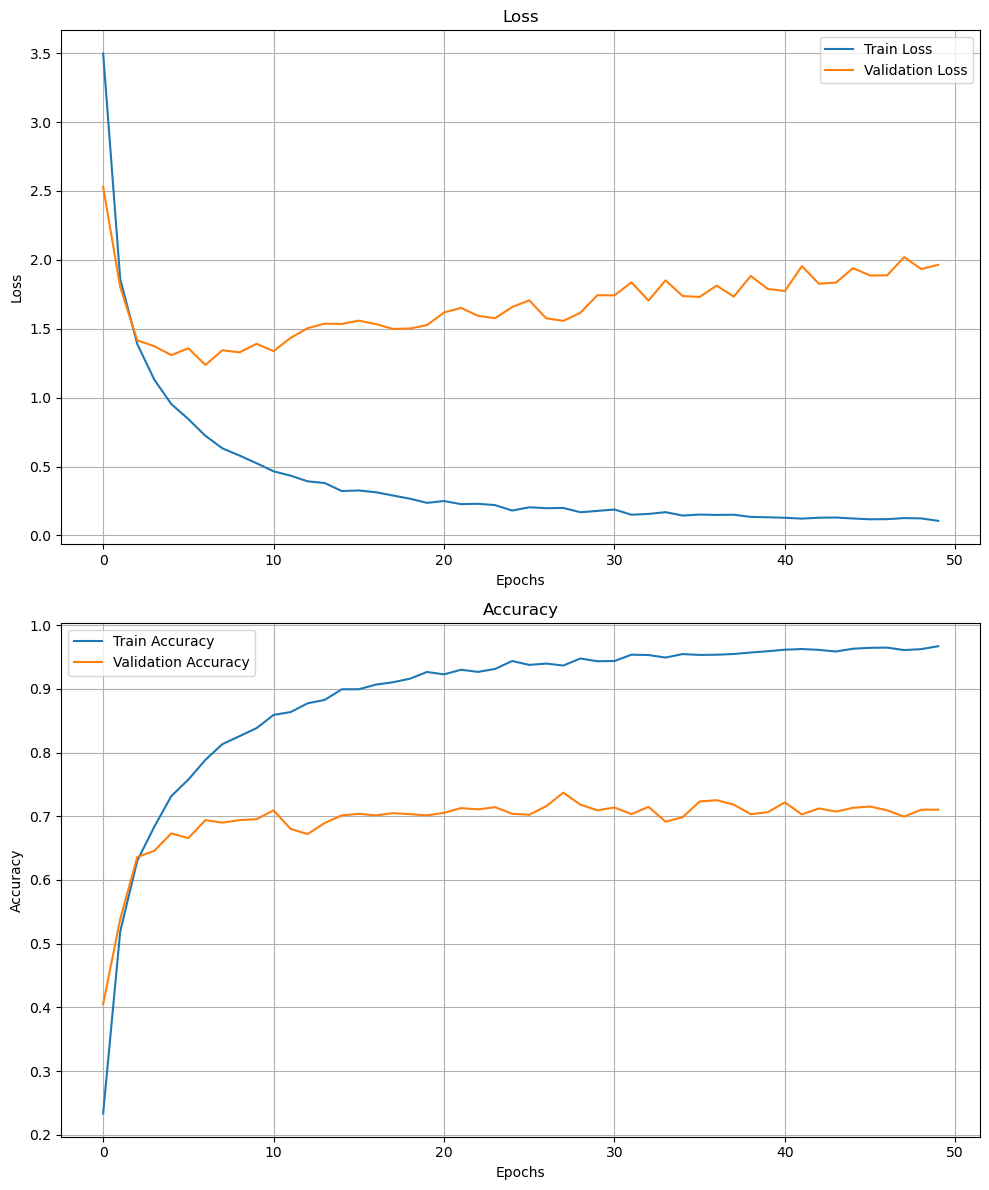

In [21]:
# Plotting the training and validation metrics
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Train and Validation Loss
axs[0].plot(history['train_loss'], label='Train Loss')
axs[0].plot(history['val_loss'], label='Validation Loss')
axs[0].set_title('Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid()

# Train and Validation Accuracy
axs[1].plot(history['train_acc'], label='Train Accuracy')
axs[1].plot(history['val_acc'], label='Validation Accuracy')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

In [22]:
from sklearn.metrics import f1_score

# Function to perform inference and compute metrics
def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    model.to(device)

    all_preds = []
    all_targets = []
    total_loss = 0.0

    with torch.no_grad():  # Disable gradient computation
        for inputs, targets in tqdm(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            # Get predictions
            _, preds = torch.max(outputs, 1)

            # Store predictions and true labels
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Compute F1 Score
    f1 = f1_score(all_targets, all_preds, average='weighted')

    # Compute average loss
    avg_loss = total_loss / len(dataloader)

    return f1, avg_loss

# Example usage
criterion = CrossEntropyLoss().to(device)
f1, avg_loss = evaluate_model(model, test_dataloader, criterion, device)
print(f"F1 Score: {f1}")
print(f"Cross-Entropy Loss: {avg_loss}")

100%|██████████| 68/68 [00:26<00:00,  2.54it/s]

F1 Score: 0.726003348830193
Cross-Entropy Loss: 1.8189436197280884


In [26]:
import torch
import torch.onnx
from sklearn.preprocessing import LabelEncoder
import pickle

# Create dummy input of shape (batch_size, channels, height, width)
dummy_input = torch.randn(1, 3, 224, 224).to(device)  # Batch size of 1, 3 channels (RGB), 224x224 image

# Save the PyTorch model as ONNX
onnx_file_path = "efficientnet_b7.onnx"
torch.onnx.export(
    model, 
    dummy_input, 
    onnx_file_path, 
    input_names=["input"], 
    output_names=["output"], 
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
)
print(f"ONNX model saved to {onnx_file_path}")

# Save the label encoder's key/value mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)
label_mapping_file = "label_mapping.pkl"

with open(label_mapping_file, "wb") as f:
    pickle.dump(label_mapping, f)
print(f"Label mapping saved to {label_mapping_file}")

# Load and verify the saved label mapping (sanity check)
with open(label_mapping_file, "rb") as f:
    loaded_label_mapping = pickle.load(f)
print(f"Loaded label mapping: {loaded_label_mapping}")

ONNX model saved to efficientnet_b7.onnx
{'airplane': 0, 'alarm clock': 1, 'angel': 2, 'ant': 3, 'apple': 4, 'arm': 5, 'armchair': 6, 'ashtray': 7, 'axe': 8, 'backpack': 9, 'banana': 10, 'barn': 11, 'baseball bat': 12, 'basket': 13, 'bathtub': 14, 'bear (animal)': 15, 'bed': 16, 'bee': 17, 'beer-mug': 18, 'bell': 19, 'bench': 20, 'bicycle': 21, 'binoculars': 22, 'blimp': 23, 'book': 24, 'bookshelf': 25, 'boomerang': 26, 'bottle opener': 27, 'bowl': 28, 'brain': 29, 'bread': 30, 'bridge': 31, 'bulldozer': 32, 'bus': 33, 'bush': 34, 'butterfly': 35, 'cabinet': 36, 'cactus': 37, 'cake': 38, 'calculator': 39, 'camel': 40, 'camera': 41, 'candle': 42, 'cannon': 43, 'canoe': 44, 'car (sedan)': 45, 'carrot': 46, 'castle': 47, 'cat': 48, 'cell phone': 49, 'chair': 50, 'chandelier': 51, 'church': 52, 'cigarette': 53, 'cloud': 54, 'comb': 55, 'computer monitor': 56, 'computer-mouse': 57, 'couch': 58, 'cow': 59, 'crab': 60, 'crane (machine)': 61, 'crocodile': 62, 'crown': 63, 'cup': 64, 'diamond':

In [25]:
!pip install onnx-pytorch

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 3.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 48.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 37.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 11.1 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppres